In [1]:
import sys, os

env_root = '/N/project/baby_vision_curriculum/pythonenvs/hfenv/lib/python3.10/site-packages/'
sys.path.insert(0, env_root)

os.environ['OPENBLAS_NUM_THREADS'] = '38' #@@@@ to help with the num_workers issue
os.environ['OMP_NUM_THREADS'] = '1'  #10

import numpy as np
import torch, torchvision
from torchvision import transforms as tr
from tqdm import tqdm
from pathlib import Path
# import math
import argparse
import pandas as pd
import warnings

import transformers

In [9]:
def get_config(image_size, args, num_labels=2):
    arch_kw = args.architecture
    if arch_kw=='small2':
        hidden_size = 768
        intermediate_size = 4*768
        num_attention_heads = 6
        num_hidden_layers = 6
        
        config = transformers.VideoMAEConfig(image_size=image_size, patch_size=16, num_channels=3,
                                             num_frames=16, tubelet_size=2, 
                                             hidden_size=hidden_size, num_hidden_layers=num_hidden_layers, num_attention_heads=num_attention_heads,
                                             intermediate_size=intermediate_size, num_labels=num_labels)
    
    elif arch_kw=='base': #default
        config = transformers.VideoMAEConfig(image_size=image_size, patch_size=16, num_channels=3,
                                             num_frames=16, tubelet_size=2, 
                                             hidden_size=768, num_hidden_layers=12, num_attention_heads=12,
                                             intermediate_size=3072, num_labels=num_labels)
    elif arch_kw=='small1':
        hidden_size = 384
        intermediate_size = 4*384
        num_attention_heads = 6
        num_hidden_layers = 12
        
        config = transformers.VideoMAEConfig(image_size=image_size, patch_size=16, num_channels=3,
                                             num_frames=16, tubelet_size=2, 
                                             hidden_size=hidden_size, num_hidden_layers=num_hidden_layers, num_attention_heads=num_attention_heads,
                                             intermediate_size=intermediate_size, num_labels=num_labels)
        
    elif arch_kw=='small3':
        hidden_size = 384
        intermediate_size = 4*384
        num_attention_heads = 6
        num_hidden_layers = 6
        
        config = transformers.VideoMAEConfig(image_size=image_size, patch_size=16, num_channels=3,
                                             num_frames=16, tubelet_size=2, 
                                             hidden_size=hidden_size, num_hidden_layers=num_hidden_layers, num_attention_heads=num_attention_heads,
                                             intermediate_size=intermediate_size)
        
    else:
        raise ValueError
    return config


def init_model_from_checkpoint(model, checkpoint_path):
    # caution: model class
    if not torch.cuda.is_available():
        checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))
    else:
        checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    return model

def adapt_videomae(source_model, target_model):
    # load the embeddings
    target_model.videomae.embeddings.load_state_dict(
        source_model.videomae.embeddings.state_dict())
#     load the encoder
    target_model.videomae.encoder.load_state_dict(
        source_model.videomae.encoder.state_dict())
    return target_model

def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False
        for param in model.classifier.parameters():
            param.requires_grad = True
            
def get_model(image_size, num_labels, feature_extracting, args):
    config_source = get_config(image_size, args)
    model_source = transformers.VideoMAEForPreTraining(config_source)
    
    if args.init_checkpoint_path!='na':
        print('args.init_checkpoint_path:',args.init_checkpoint_path)
        # initialize the model using the checkpoint
        model_source = init_model_from_checkpoint(model_source, args.init_checkpoint_path)
  
    config_target = get_config(image_size, args, num_labels=num_labels)
    model_target = transformers.VideoMAEForVideoClassification(config=config_target)
    model_target = adapt_videomae(model_source, model_target)
    if not torch.all(
        model_target.videomae.embeddings.patch_embeddings.projection.weight==model_source.videomae.embeddings.patch_embeddings.projection.weight):
        warnings.warn('Model not successfully initialized')
    
#     if feature_extracting:
#         set_parameter_requires_grad(model_target, feature_extracting)
    
    return model_target

In [3]:
class Args:
    def __init__(self, **kwargs):
        for key, value in kwargs.items():
            setattr(self, key, value)

In [4]:
ch_dir = '/N/project/baby_vision_curriculum/trained_models/generative/v2/may14/s1/'
init_checkpoint_path=ch_dir+"model_g0_seed_211_other_211_sgd.pt"

savedir='/N/project/baby_vision_curriculum/trained_models/generative/v2/analyses/'

frame_rate=10
batch_size=64
num_workers=45#6
architecture='base'
args = Args(architecture=architecture,
            init_checkpoint_path=init_checkpoint_path,
            savedir=savedir,
            frame_rate=frame_rate,
            num_workers=num_workers,
            batch_size=batch_size)
image_size = 224
feature_extract = True#(args.finetune=='n')
num_classes=0 # just extract embeddings
xmodel = get_model(image_size, num_classes, feature_extract, args)


In [16]:
weights =xmodel.videomae.embeddings.patch_embeddings.projection.weight.data

In [14]:
import matplotlib.pyplot as plt

100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 266.94it/s]


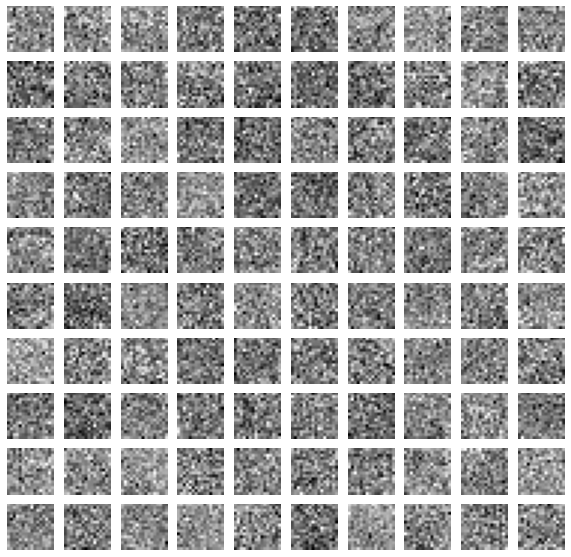

In [22]:
cweights = weights012#
fig,ax = plt.subplots(10,10, figsize=(10,10))

start_idx = 0
rgb_idx = 0
t_idx = 0
for i in tqdm(range(10)):
    for j in range(10):
        cax = ax[i,j]
        cidx = start_idx+ i*10+j
        cdata = cweights[cidx, rgb_idx, t_idx,...]
        cax.imshow(cdata, cmap='gray')
        cax.set_axis_off()

In [38]:
ch_dir = '/N/project/baby_vision_curriculum/trained_models/generative/v2/may14/s3/'
init_checkpoint_path=ch_dir+"model_g2_seed_211_other_211_sgd_pre.g0g1.pt"

savedir='/N/project/baby_vision_curriculum/trained_models/generative/v2/analyses/'

frame_rate=10
batch_size=64
num_workers=45#6
architecture='base'
args = Args(architecture=architecture,
            init_checkpoint_path=init_checkpoint_path,
            savedir=savedir,
            frame_rate=frame_rate,
            num_workers=num_workers,
            batch_size=batch_size)
image_size = 224
feature_extract = True#(args.finetune=='n')
num_classes=0 # just extract embeddings
xmodel012 = get_model(image_size, num_classes, feature_extract, args)


args.init_checkpoint_path: /N/project/baby_vision_curriculum/trained_models/generative/v2/may14/s3/model_g2_seed_211_other_211_sgd_pre.g0g1.pt


In [39]:
weights012 =xmodel.videomae.embeddings.patch_embeddings.projection.weight.data

100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 17.31it/s]


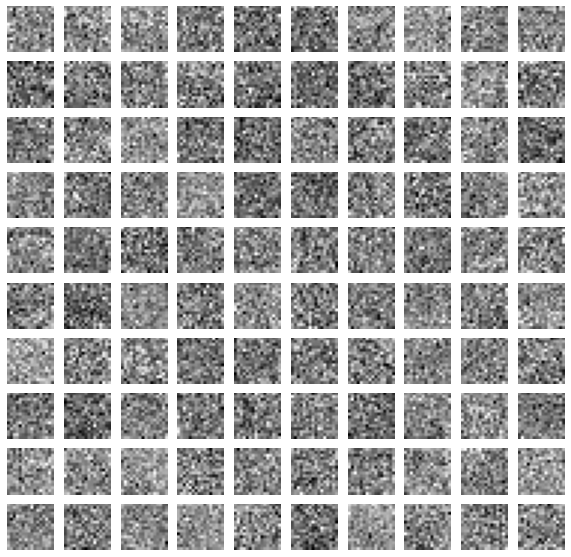

In [40]:
cweights = weights012#
fig,ax = plt.subplots(10,10, figsize=(10,10))

start_idx = 0
rgb_idx = 0
t_idx = 0
for i in tqdm(range(10)):
    for j in range(10):
        cax = ax[i,j]
        cidx = start_idx+ i*10+j
        cdata = cweights[cidx, rgb_idx, t_idx,...]
        cax.imshow(cdata, cmap='gray')
        cax.set_axis_off()

In [25]:
ch_dir = '/N/project/baby_vision_curriculum/trained_models/generative/v2/may14/s3/'
init_checkpoint_path=ch_dir+"model_g0_seed_211_other_211_sgd_pre.g2g1.pt"

savedir='/N/project/baby_vision_curriculum/trained_models/generative/v2/analyses/'

frame_rate=10
batch_size=64
num_workers=45#6
architecture='base'
args = Args(architecture=architecture,
            init_checkpoint_path=init_checkpoint_path,
            savedir=savedir,
            frame_rate=frame_rate,
            num_workers=num_workers,
            batch_size=batch_size)
image_size = 224
feature_extract = True#(args.finetune=='n')
num_classes=0 # just extract embeddings
xmodel012 = get_model(image_size, num_classes, feature_extract, args)


args.init_checkpoint_path: /N/project/baby_vision_curriculum/trained_models/generative/v2/may14/s3/model_g0_seed_211_other_211_sgd_pre.g2g1.pt


In [26]:
weights210 =xmodel.videomae.embeddings.patch_embeddings.projection.weight.data

100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 268.33it/s]


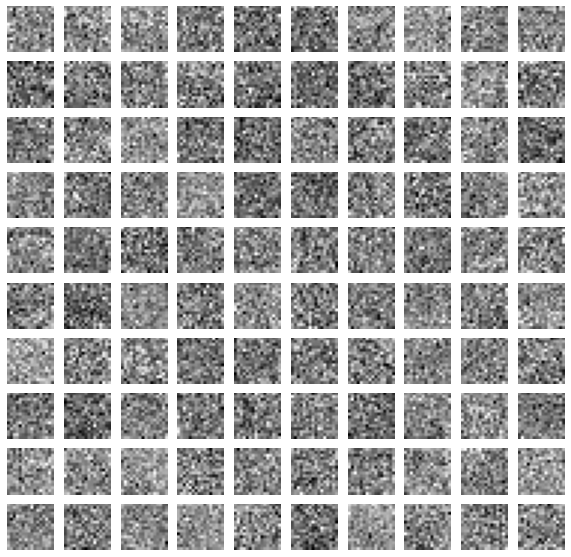

In [33]:
cweights = weights210#
fig,ax = plt.subplots(10,10, figsize=(10,10))

start_idx = 0
rgb_idx = 0
t_idx = 0
for i in tqdm(range(10)):
    for j in range(10):
        cax = ax[i,j]
        cidx = start_idx+ i*10+j
        cdata = cweights[cidx, rgb_idx, t_idx,...]
        cax.imshow(cdata, cmap='gray')
        cax.set_axis_off()

In [41]:
ch_dir = '/N/project/baby_vision_curriculum/trained_models/generative/v2/may14/s3/'
init_checkpoint_path=ch_dir+"model_g2_seed_211_other_211_sgd_pre.g2g2.pt"

savedir='/N/project/baby_vision_curriculum/trained_models/generative/v2/analyses/'

frame_rate=10
batch_size=64
num_workers=45#6
architecture='base'
args = Args(architecture=architecture,
            init_checkpoint_path=init_checkpoint_path,
            savedir=savedir,
            frame_rate=frame_rate,
            num_workers=num_workers,
            batch_size=batch_size)
image_size = 224
feature_extract = True#(args.finetune=='n')
num_classes=0 # just extract embeddings
xmodel222 = get_model(image_size, num_classes, feature_extract, args)


args.init_checkpoint_path: /N/project/baby_vision_curriculum/trained_models/generative/v2/may14/s3/model_g2_seed_211_other_211_sgd_pre.g2g2.pt


In [42]:
weights222 =xmodel.videomae.embeddings.patch_embeddings.projection.weight.data

100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 267.15it/s]


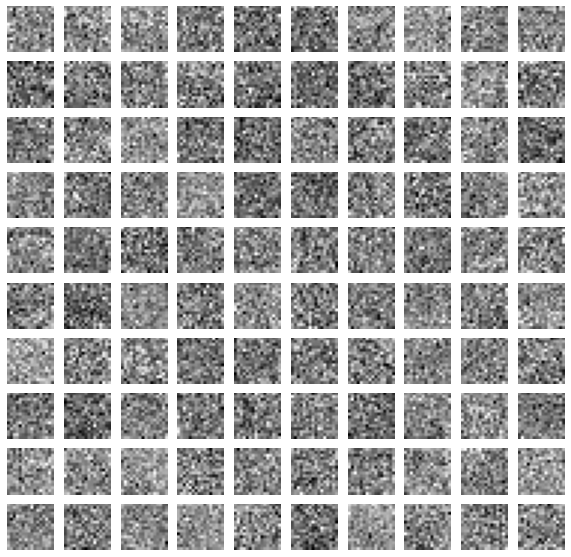

In [43]:
cweights = weights222#
fig,ax = plt.subplots(10,10, figsize=(10,10))

start_idx = 0
rgb_idx = 0
t_idx = 0
for i in tqdm(range(10)):
    for j in range(10):
        cax = ax[i,j]
        cidx = start_idx+ i*10+j
        cdata = cweights[cidx, rgb_idx, t_idx,...]
        cax.imshow(cdata, cmap='gray')
        cax.set_axis_off()

In [37]:
cweights.shape

torch.Size([768, 3, 2, 16, 16])

In [ ]:
# maybe if we want to do receptive field analysis, we should run the models (g0 and g2) to convergence.
